# Samantha Gilbert

## Homework #3

## Galaxies

## Winter 2021

In [51]:

#---------------------------------Import modules----------------------------------# 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy.integrate import quad
from scipy.stats import norm
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

#---------------------------------------------------------------------------------#

In [52]:
#---------------------------------Read in data----------------------------------# 

# "Truth" Data

truth_data = pd.read_csv('./Desktop/galaxies_hw3/LSSTsimWDtruth60.dat', delim_whitespace=True)

# • ra dec: right ascension and declination (J2000.0) in decimal degrees

# • u g r i z y: “true magnitudes in LSST bandpasses (based on the
#                 Bergeron white dwarf models, no correction for the ISM extinction)

# • Mr: absolute magnitude, Mr, in the r band (drawn from the Harris et al. luminosity function)

# • log(g): set to 8.0 for all stars

# • vR, vφ, vZ: model velocity in galactocentric cylindrical coordinates 
#               R points away from the galactic center, Z points towards 
#               the North Galactic Pole, and the coordinate system is right-handed; 
#               the Sun is at (R=8 kpc, Z=25 pc) and the local standard of rest rotates 
#               with vφ = 220 km/s). The velocity distribution is drawn from the Bond et al. 
#               2010 (ApJ, 716, 1) model.
              
# • T: WD model type; 1=Hydrogen WD, 2=He WD (color tracks depend on this type), 10% of 
#      the population is randomly assigned T=2.
     
# • P: Galactic population: 1=disk, 2=halo (population assignment and overall spatial 
#      distribution is drawn from the Juri ́c et al. 2008 (ApJ, 684, 287) model.

# Observational Data

observ_data = pd.read_csv('./Desktop/galaxies_hw3/LSSTsimWDobs60.dat', delim_whitespace=True)


# • ra dec: right ascension and declination (J2000.0) in decimal degrees

# • mObs, mErr; m=(u, g, r, i, z, y): “observed magnitudes, generated by convolving truth 
#                                     magnitudes with expected LSST errors (not corrected for 
#                                     the ISM extinction). The expected errors are computed as 
#                                     described in the LSST overview paper 1 
#                                     (Ivezic et al. 2019; ApJ, 873, 111).
                                    
# • piObs, piErr: trigonometric parallax and its expected error, in milliarcsec (the listed 
#                 parallax is generated by convolving the true parallax with expected error; 
#                 the true parallax is computed from true distance, with the latter determined 
#                 from Mr and true r). The parallax error is computed as described in the LSST 
#                 overview paper(see section 3.3.3).
                
# • muRAObs, muDecObs, muErr: the components of the proper mo- tion vector in the R.A. and Dec 
#                             directions, and the proper motion error (per coordinate), 
#                             in milliarcsec/yr. The proper motion is generated using velocity 
#                             from the first file and by convolving the true proper motion with 
#                             the expected proper motion error (the latter is computed as 
#                             described in the LSST overview paper, see section 3.3.3).

### Problem A

We begin by slicing the data by requiring a signal-to-noise ratio of at least 10 for the trigonometric parallax measurement, where

$$ \textrm{SNR} = \frac{piObs}{piErr} $$

In [53]:
piObs = observ_data['piObs']
piErr = observ_data['piErr']

# We define a function to calculate the SNR.

def calc_snr(piObs, piErr):
    snr = piObs/piErr
    return snr

# We slice the data by requiring SNR > 10. 

snr_mask = calc_snr(piObs, piErr) > 10
observ_slice = observ_data[snr_mask]

Next, we compute the distance and distance modulus from the parallax measurement, where

$$ \frac{D}{\textrm{kpc}} = \frac{1\:\textrm{milliarcsec}}{piObs}  $$

and the distance modulus is given by

$$ \delta{d} = 5\log{\frac{r}{10}} $$

where $r$ is distance in parsecs.

In [54]:
# We define a function to calculate the distance from the parallax measurement.
def distance(piObs):
    d = 1000 / piObs
    return d # in kpc

# We define a function to calculate the distance modulus from the parallax measurement.
def modulus(piObs):
    del_d = 5 * np.log10(distance(piObs) / 10)
    return del_d

dist_obs = distance(observ_slice['piObs'])
mod_obs = modulus(observ_slice['piObs'])

We now compare the distance modulus from the parallax measurements to the distance modulus determined from $r$ and $M_r$ listed in the “truth” file, where

$$ \delta{d} = m - M_r $$

Here, $m$ is the apparent magnitude (so-called $r$ in our data file) and $M_r$ is the absolute magnitude.

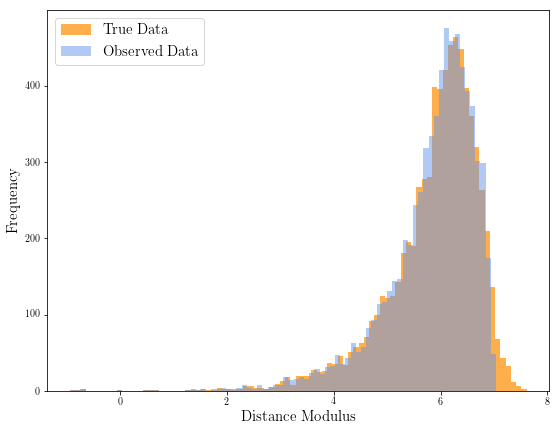

In [55]:
# Slice the true data
mod_slice = truth_data[snr_mask]

# Calculate the distance modulus for the true data using apparent/absolute magnitudes
mod_true = mod_slice['r'] - mod_slice['Mr']

plt.figure(figsize=[9,7])
plt.hist(x=mod_true, bins='auto', label='True Data', color='darkorange', alpha=0.7)
plt.hist(x=mod_obs, bins='auto', label='Observed Data', color='cornflowerblue', alpha=0.5)
plt.xlabel('Distance Modulus', fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.legend(fontsize=15)
plt.show()

We observe that the distance moduli for the sliced datasets for the observed data and the true data line up pretty well, but that the observed data lacks a tail at higher distance moduli values (e.g., $\delta{d}>7$). Higher distance moduli correspond to more distant and thus "fainter" stars. It makes sense that our observations would be biased against collecting data for these objects because they are probably too faint to detect, explaining the gap at large $m - M$.

We now  plot the distribution of the distance modulus difference and compute its median and root-mean-square scatter, clipping the data at $\pm3\sigma$ to eliminate outliers.

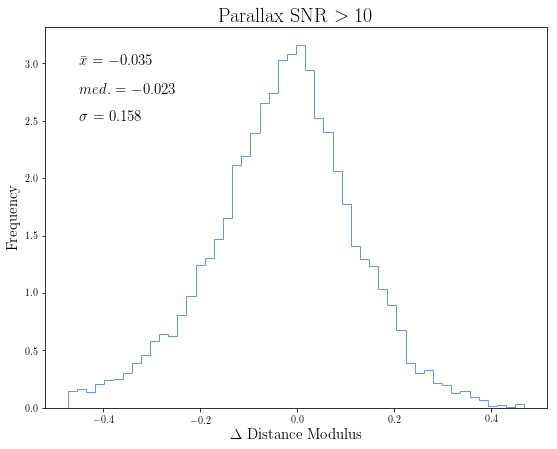

In [56]:
# Calculate the difference in distance modulus for true and observed data
difference = mod_obs - mod_true

# Calculate 3 sigma
maxi = (3*np.std(difference)) 
mini = (-3*np.std(difference)) 

# Clip the outlers at +/- 3 sigma
clip_outliers = np.logical_and(difference > mini, difference < maxi)
difference_clip = difference[clip_outliers]
     
plt.figure(figsize=[9,7])
plt.hist(x=difference_clip, bins='auto', density=True, color='cornflowerblue', histtype='step')
plt.xlabel('$\Delta$ Distance Modulus', fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.title("Parallax SNR $>10$", fontsize=20)
plt.text(-0.45,3.00,("$\\bar{{x}}$ = ${:.3f}$".format(np.mean(difference))), fontsize=15)
plt.text(-0.45,2.75,("$med.$ = ${:.3f}$".format(np.median(difference))), fontsize=15)
plt.text(-0.45,2.50,("$\sigma$ = ${:.3f}$".format(np.std(difference))), fontsize=15)
plt.show()

We want to compare this distribution to its corresponding normal distribution given the mean and $\sigma$ that we calculated.

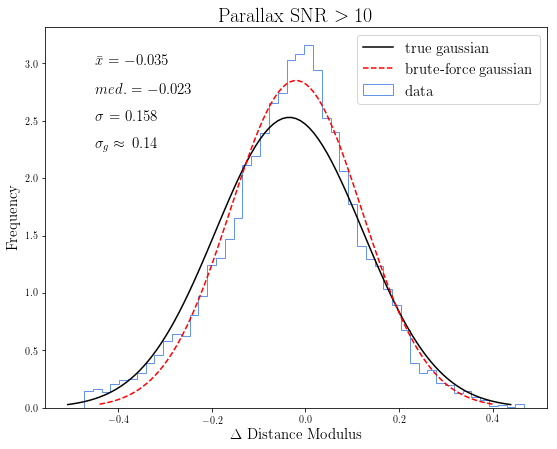

In [57]:
# Define the parameters for a corresponding normal distribution
mu = np.mean(difference)
sigma = np.std(difference)
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100) # Cut off at +/- 3 sigma

# After playing around with some numbers, roughly estimate a Gaussian that "looks" like a better fit
mu_g = -0.02
sigma_g = 0.14
x_g = np.linspace(mu_g - 3*sigma_g, mu_g + 3*sigma_g, 100) # Cut off at +/- 3 sigma

# Plot the data with the corresponding normal distribution and a brute-force, better-fit Gaussian for fun
plt.figure(figsize=[9,7])
plt.hist(x=difference_clip, bins='auto', density=True, color='cornflowerblue', histtype='step', label = 'data')
plt.plot(x, norm.pdf(x, mu, sigma), color='k', linestyle='-', label='true gaussian')
plt.plot(x_g, norm.pdf(x_g, mu_g, sigma_g), color='r', linestyle='--', label='brute-force gaussian')

plt.xlabel('$\Delta$ Distance Modulus', fontsize=15)
plt.ylabel("Frequency", fontsize=15)
plt.title("Parallax SNR $>10$", fontsize=20)

plt.text(-0.45,3.00,("$\\bar{{x}}$ = ${:.3f}$".format(np.mean(difference))), fontsize=15)
plt.text(-0.45,2.75,("$med.$ = ${:.3f}$".format(np.median(difference))), fontsize=15)
plt.text(-0.45,2.50,("$\sigma$ = ${:.3f}$".format(np.std(difference))), fontsize=15)
plt.text(-0.45,2.25,("$\sigma_g\\approx\:{:.2f}$".format(0.14)), fontsize=15)
plt.legend(loc='best', fontsize=15)

plt.show()

We can see that the data is not exactly normally distributed. We find a higher frequency of stars around $\Delta{d} = 0$ than we would have predicted with a corresponding normal distribution.  We would prefer Gaussian errors, as this would indicate that our errors arise due to randomness rather than a systematic error. That our distribution slightly deviate from a Gaussian suggests that we have wider tails than expected. Furthermore, that our distribution is not exactly centered at zero suggests that we are slightly skewed towards underestimated the observed distance moduli, since  
$$\Delta DM = DM_\textrm{obs} - DM_\textrm{true} \rightarrow  DM_\textrm{obs} < DM_\textrm{true} \rightarrow \Delta DM < 0$$ 

Despite these deviations, we observe that our distribution is still close to a Gaussian after implementing the $\pm 3\sigma$ cuts, and we conclude that we will ignore the effects of the bias and errors.

We now want to calculate how many white dwarfs we would expect in a “gold parallax sample” from the full LSST survey area of 20,000 deg$^2$. As suggested in the hint, we will simply scale by the area because the distance cutoff is smaller than the thin disk scale height. To accomplish this, we will count the number of stars within our SNR cutoff, $N_{\textrm{sample}}$. Next, we will calculate the area of the sample by integrating over the surface of a sphere using the fact that we are given $b > 60^{\circ}$:

$$ A_{\textrm{sample}} = \int_0^{2\pi} \int_\frac{5\pi}{6}^\pi \sin(b)\: db \: dl $$

This will give an integral in Sr that we will convert to deg$^2$. Then, we will take the total LSST area, finding

$$ N_{\textrm{WD}} \approx \frac{20000}{A_{\textrm{sample}}} \times N_{\textrm{sample}}$$

In [58]:
# Number of stars within SNR cutoff
n_sample = len(observ_slice)

# Surface area integral
sinx = lambda a: np.sin(a)
area_sample = 2 * np.pi * quad(sinx, (5*np.pi)/6, np.pi)[0] * 3283

# Total survey area
LSST_area = 20000 # deg^2

# Calculate number of WDs in sample
N_wd = (LSST_area / area_sample) * n_sample
print("The approximate number of White Dwarfs in the LSST survey is {}.".format(np.rint(N_wd)))

The approximate number of White Dwarfs in the LSST survey is 51788.0.


Finally, we want to compare our data to similar visualizations of SDSS data in Ivezic et. al 2007. We plot a color-color diagram, with filters $g - r$ on the $y$-axis and $u - g$ on the $x$-axis.

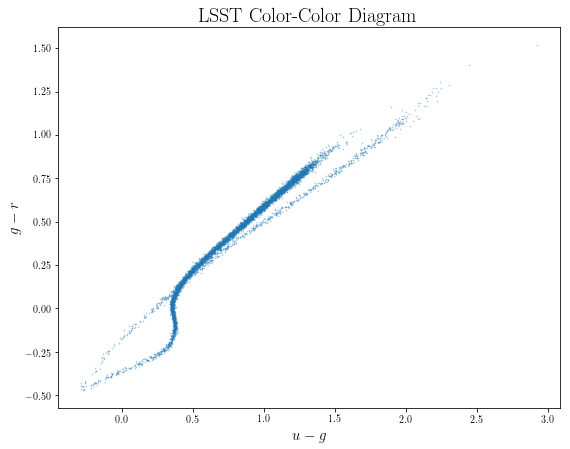

In [59]:
g_r = observ_slice['gObs'] - observ_slice['rObs']
u_g = observ_slice['uObs'] - observ_slice['gObs']

plt.figure(figsize=[9,7])
plt.scatter(u_g, g_r, s=0.3, alpha=0.4)
plt.ylabel('$g - r$', fontsize=15)
plt.xlabel("$u - g$", fontsize=15)
plt.title("LSST Color-Color Diagram", fontsize=20)
plt.show()

A comparison of the bottom 2 panels of figure 24 in Ivezic et. al 2007 shows that multiple observations of the same field (e.g., "multiepoch observations") improve our ability to accurately determine the colors of nonvariable sources. 

As the next generation large survey telescope, LSST will find roughly ten times as many galaxies per unit area than the Sloan Digital Sky Survey (SDSS). Furthermore, LSST will have better resolution than SDSS, covering a larger field of view in 6 different optical bands. Importantly, LSST will also scan this area multiple times per month over a 10 year period.

We can see in our plot that the data has much less spread than in the SDSS plots. This makes sense given what we know about LSST's improvements upon SDSS. We anticipate that LSST data will be much crisper than its SDSS counterpart because it plans to do multiepoch observations. 

### Problem B

Using the “gold parallax sample” from A, we will estimate the absolute r band magnitude as 

$$ M_{\textrm{obs}} = r_{\textrm{obs}} − DM_{\textrm{obs}}$$ 

with the observed distance modulus, $DM_{\textrm{obs}}$, determined using the “measured” trigonometric parallax, $pi_{\textrm{obs}}$. Then, we will plot $M_{\textrm{obs}}$ vs. $(g_{\textrm{obs}}−r_{\textrm{obs}})$ color for stars with $T=1$.

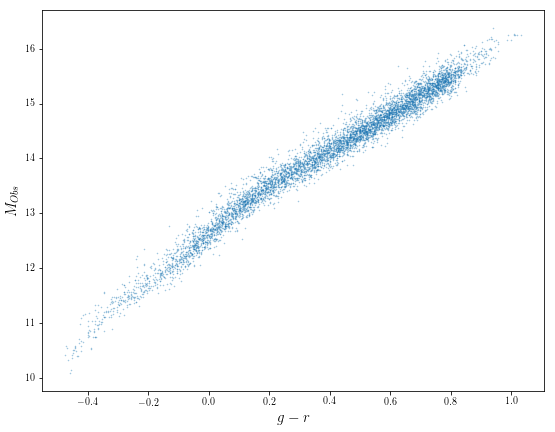

In [60]:
def abs_mag(rObs,DMObs):
    MObs = rObs - DMObs
    return MObs

# Create a new slice of the observed data for stars with T=1
hydr_wd = observ_slice[mod_slice['T']==1]

# Calculate the absolute magnitude using our measured parallax values.
MObs_arr = abs_mag(hydr_wd['rObs'], modulus(hydr_wd['piObs']))

g_r_wd = hydr_wd['gObs'] - hydr_wd['rObs']

plt.figure(figsize=[9,7])
plt.scatter(g_r_wd, MObs_arr, s=0.3, alpha=0.4)
plt.ylabel('$M_{Obs}$', fontsize=15)
plt.xlabel("$g - r$", fontsize=15)
plt.show()

Now, we will fit a low-order polynomial to derive a photometric parallax relation, $M_r(g−r)$.  Following the hint, we will first compute the median $M_r$ in $g - r$ bins of width 0.1 mag, and fit a polynomial to these median values vs. $g − r$ bin value. Deriving our functional relationship this way will ensure that our fit is less suscpetible to outliers. We will fit and compare a linear, quadratic, and cubic function to the medians and compare the residuals to pick the best polynomial fit.

In [61]:
# Calculate the number of bins for width = 0.1.
bins = (np.max(g_r_wd) - np.min(g_r_wd)) / 0.1 

# Store an array for binned medians of MObs.
medians, bin_edges, n_bin = scipy.stats.binned_statistic(g_r_wd, MObs_arr, statistic='median', bins=bins)
x_bins = (bin_edges[1:] + bin_edges[:-1])/2

# Fit a linear   
fit_1, residuals_1, rank, singular_values, rcond = np.polyfit(x_bins, medians, 1, full=True)
residuals_1 = np.float(residuals_1)

# Function to express the linear fit
def fit_func_lin(x):
    poly_fit = fit_1[0]*x + fit_1[1]
    return poly_fit

# Fit a quadratic   
fit_2, residuals_2, rank, singular_values, rcond = np.polyfit(x_bins, medians, 2, full=True)
residuals_2 = np.float(residuals_2)

# Function to express the quadratic fit 
def fit_func_quad(x):
    poly_fit = fit_2[0]*x**2 + fit_2[1]*x + fit_2[2]
    return poly_fit
      
# Fit a cubic  
fit_3, residuals_3, rank, singular_values, rcond = np.polyfit(x_bins, medians, 3, full=True)
residuals_3 = np.float(residuals_3)

# Function to express the cubic fit 
def fit_func_cub(x):
    poly_fit = fit_3[0]*x**3 + fit_3[1]*x**2 + fit_3[2]*x + fit_3[3]
    return poly_fit

# Fit a quartic
fit_4, residuals_4, rank, singular_values, rcond = np.polyfit(x_bins, medians, 4, full=True)
residuals_4 = np.float(residuals_4)

# Function to express the quartic fit 
def fit_func_quart(x):
    poly_fit = fit_4[0]*x**4 + fit_4[1]*x**3 + fit_4[2]*x**2 + fit_4[3]*x + fit_4[4]
    return poly_fit

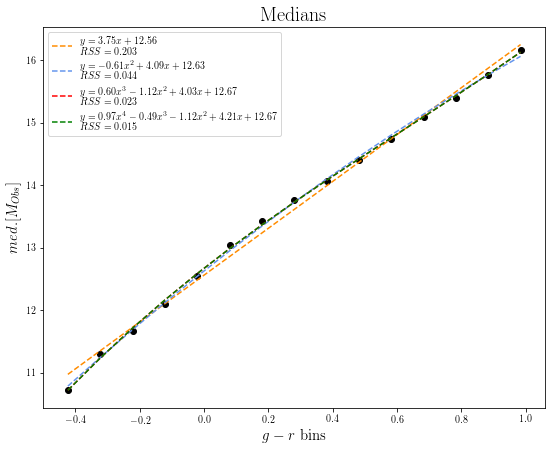

(10.722937514441341, 16.163610316161666)
(-0.42373333333333, 0.9837333333333359)


In [62]:
# Plot the medians with linear, quadratic, and cubic fits for comparison.      
plt.figure(figsize=[9,7])
plt.scatter(x_bins, medians, color='k')
plt.plot(x_bins,fit_func_lin(x_bins), 
         linestyle='--', 
         color='darkorange', 
         label='$y = {:.2f}x + {:.2f}$ \n $RSS = {:.3f}$'.format(fit_1[0], fit_1[1], residuals_1))
plt.plot(x_bins,fit_func_quad(x_bins), 
         linestyle='--', 
         color='cornflowerblue', 
         label='$y = {:.2f}x^2 + {:.2f}x + {:.2f}$ \n $RSS = {:.3f}$'.format(fit_2[0], fit_2[1], fit_2[2], residuals_2))
plt.plot(x_bins,fit_func_cub(x_bins), 
         linestyle='--', 
         color='red', 
         label='$y = {:.2f}x^3 {:.2f}x^2 + {:.2f}x + {:.2f}$ \n $RSS = {:.3f}$'.format(fit_3[0], fit_3[1], fit_3[2], fit_3[3], residuals_3))
plt.plot(x_bins,fit_func_cub(x_bins), 
         linestyle='--', 
         color='green', 
         label='$y = {:.2f}x^4 {:.2f}x^3 {:.2f}x^2 + {:.2f}x + {:.2f}$ \n $RSS = {:.3f}$'.format(fit_4[0], fit_4[1], fit_4[2], fit_4[3], fit_4[4], residuals_4))
plt.ylabel('$med.[M_{Obs}]$', fontsize=15)
plt.xlabel("$g - r$ bins", fontsize=15)
plt.title("Medians", fontsize=20)
plt.legend(fontsize=10)
plt.show()

print(np.min(medians),np.max(medians))
print(np.min(x_bins),np.max(x_bins))

The quartic polynomial presents the fit with the smallest residual. Barring higher order polynomials that may have lower residuals but also may introduce overfitting problems, we will choose the quartic polynomial as our functional form. This relationship should be valid for $\approx10.7 < M_r < 16.2$ and $\approx-0.42 < g - r < 0.98$.

### Problem C

We now wish to define a “gold proper motion sample” by requiring $r_{\textrm{obs}} < 24.5$.
We will also require an SNR $\geq 3$. To compute the SNR, we add the two proper motion components in quadrature and divide by the listed proper motion error such that

$$ SNR = \frac{\sqrt{(\mu_{\textrm{RA}})^2 + (\mu_{\textrm{dec}})^2}}{\mu_{\textrm{err}}} $$

In [63]:
# A function to calculate the proper motion SNR
def calc_snr(muRAObs, muDecObs, muErr):
    prop_snr = np.sqrt((muRAObs)**2 + (muDecObs)**2) / muErr
    return prop_snr

# Slice the data by requiring rObs < 24.5
prop_observ = observ_data[observ_data['rObs'] < 24.5]

# Slice the data by requiring SNR >= 3
snr_mask_2 = calc_snr(prop_observ['muRAObs'], prop_observ['muDecObs'], prop_observ['muErr']) >= 3
prop_slice = prop_observ[snr_mask_2]

print(len(prop_slice))
print(len(prop_observ))

178244
182757


We find that 178244/182757 = 97.5% of the data make this SNR cut. 

We will now apply our photometric parallax relation from B to estimate $M_r$
and distance using $M_r$ and $r_{\textrm{Obs}}$. 

In [64]:
def est_Mr(x):
    estimate = (fit_4[0])*x**4 + (fit_4[1])*x**3 + (fit_4[2])*x**2 + (fit_4[3])*x + fit_4[4]
    return estimate

def calc_distance(rObs, M_r):
    distance = 10 ** ((rObs-M_r)/5 + 1) 
    return distance # in pc

estimated_Mr = est_Mr(prop_slice['gObs']-prop_slice['rObs'])
distances = calc_distance(prop_slice['rObs'], estimated_Mr)

We will use this distance to compute tangential velocity $v_\textrm{tan}$. To calculate this velocity, we will obtain the proper motion $\mu_\textrm{tan}$ in units of milliarcsec/year by adding $\mu_\textrm{RA}$ and $\mu_\textrm{dec}$ in quadrature so that

$$ \mu_\textrm{tan} = \sqrt{(\mu_\textrm{RA})^2 + (\mu_\textrm{dec})^2} $$

We will divide by $1000 \times 3600$ to convert this velocity to degrees/year, and then convert to radians/year. We then multiply by the distance we calculated in pc, and convert to km/s.

In [65]:
def calc_v_tan(distance, muRAObs, muDecObs):
    constant = np.pi*978462/(180*1000*3600) # unit conversion
    v_tan = constant*distance*np.sqrt((muRAObs)**2 + (muDecObs)**2) 
    return v_tan

v_tan = calc_v_tan(distances, prop_slice['muRAObs'], prop_slice['muDecObs'])

We will now define a candidate disk sample as stars with $v_\textrm{tan} < v_\textrm{tan}^\textrm{cutoff}$, and a candidate halo sample as stars with $v_\textrm{tan} > v_\textrm{tan}^\textrm{cutoff}$. The variable $P$ in the truth file gives the type of object as 1 or 2, with 1 corresponding to disk objects and 2 corresponding to halo objects. Using $P$ from the truth file, we will plot the completeness and contamination for disk and halo samples as a function of $v_\textrm{tan}^\textrm{cutoff}$ for $0 < v_\textrm{tan}^\textrm{cutoff} < 500$ km/s in steps of 20 km/s. 

We define "completeness" as the number of disk/halo objects in the selected subsample divided by the total number of such objects, and "contamination" as the number of objects of the “wrong” type in the selected subsample divided by the total number in that subsample.

In [66]:
# Define a range of v_tan cutoffs to try
v_tan_cutoffs = np.arange(20, 500, 20)

# Slice the "true" data so it matches our sliced observed data, and just take the P column
true_type = truth_data.loc[prop_slice.index, 'P']

def calc_stats(observed, true, cutoff):
    # if less than cutoff, then disk (true/1 in vector)
    observed_binarized = observed < cutoff
    # in the true labels, disk also is 1, but halo is 0 now
    true_binarized = true == 1
    
    # fraction of true disk stars that are classified correctly at this threshold
    disk_completeness = np.logical_and(observed_binarized == true_binarized,
                                       true_binarized == 1).sum() / float(true_binarized.sum())
    
    # fraction of true halo stars that are classified correctly at this threshold
    halo_completeness = np.logical_and(observed_binarized == true_binarized,
                                       true_binarized == 0).sum() / float(len(true_binarized)-true_binarized.sum())
    
    # fraction of "observed" disk stars that are actually halo objects
    disk_contamination = np.logical_and(observed_binarized != true_binarized,
                                       observed_binarized == 1).sum() / float(observed_binarized.sum())
    
    # fraction of "observed" halo stars that are actually disk objects
    halo_contamination = np.logical_and(observed_binarized != true_binarized,
                                       observed_binarized == 0).sum() / float(len(observed_binarized)-observed_binarized.sum())

    return disk_completeness, disk_contamination, halo_completeness, halo_contamination

disk_completeness_list = []
disk_contamination_list = []
halo_completeness_list = []
halo_contamination_list = []

for v in v_tan_cutoffs:
    disk_completeness, disk_contamination, halo_completeness, halo_contamination = calc_stats(v_tan, true_type, v)
    disk_completeness_list.append(disk_completeness)
    disk_contamination_list.append(disk_contamination)
    halo_completeness_list.append(halo_completeness)
    halo_contamination_list.append(halo_contamination)

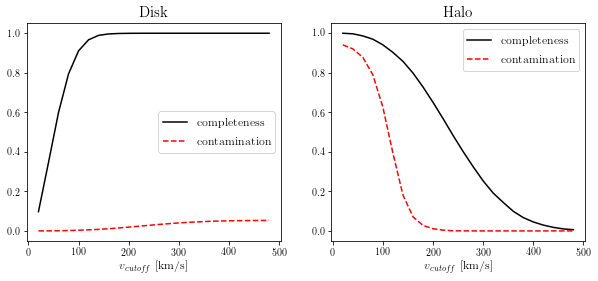

In [67]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10,4)

ax1.plot(v_tan_cutoffs, disk_completeness_list, color='k', linestyle='-', label='completeness')
ax1.plot(v_tan_cutoffs, disk_contamination_list, color='r', linestyle='--', label='contamination')
ax2.plot(v_tan_cutoffs, halo_completeness_list, color='k', linestyle='-', label='completeness')
ax2.plot(v_tan_cutoffs, halo_contamination_list, color='r', linestyle='--', label='contamination')

ax1.set_title('Disk', fontsize=15)
ax2.set_title('Halo', fontsize=15)

ax1.set_xlabel('$v_{cutoff}$ [km/s]', fontsize=12)
ax2.set_xlabel('$v_{cutoff}$ [km/s]', fontsize=12)

ax1.legend(fontsize=12)
ax2.legend(fontsize=12)

plt.show()

Our completeness and contamination plots show that halo objects in our subsample are much more susceptible to contamination by disk objects than vice versa. We can see that halo contamination is minimized around $v_\textrm{tan}^{\textrm{cutoff}} \approx 150-200$ km/s without fully compromising on halo completeness.

### Problem D

Using the “gold proper motion sample” from C, we define a candidate disk sample by requiring $v_\textrm{tan}^{\textrm{cutoff}} < 150$ km/s , and a candidate halo sample by $v_\textrm{tan}^{\textrm{cutoff}} > 200$ km/s. We then estimate the completeness and contamination for each subsample, where we will require that $-0.4 < g - r < 1.0$ as we found in **Problem B**.

In [68]:
# Create a subsample of disk objects by requiring v_tan < 150, −0.4 < 𝑔 − 𝑟 < 1
disk_objects = prop_slice[v_tan < 150]
disk_objects = disk_objects.loc[(prop_slice['gObs']-prop_slice['rObs']>-0.4) & (prop_slice['gObs']-prop_slice['rObs']<1.0)]

# Create a subsample of halo objects by requiring v_tan > 200, −0.4 < 𝑔 − 𝑟 < 1
halo_objects = prop_slice[v_tan > 200]
halo_objects = halo_objects.loc[(prop_slice['gObs']-prop_slice['rObs']>-0.4) & (prop_slice['gObs']-prop_slice['rObs']<1.0)]

# Slice the true data accordingly so that our rows continue to match up
true_slice = truth_data[observ_data['rObs'] < 24.5][snr_mask_2]
true_slice = true_slice.loc[(prop_slice['gObs']-prop_slice['rObs']>-0.4) & (prop_slice['gObs']-prop_slice['rObs']<1.0)]
true_disk = true_slice[v_tan < 150]
true_halo = true_slice[v_tan > 200]

# Calculate completeness and contamination for the subsamples
disk_completeness, disk_contamination, __, ___ = calc_stats(v_tan, true_type, 150)
__, ___, halo_completeness, halo_contamination = calc_stats(v_tan, true_type, 200)

# Report completeness and contamination
print('Disk completeness = {}'.format(disk_completeness))
print('Disk contamination = {}'.format(disk_contamination))
print('Halo completeness = {}'.format(halo_completeness))
print('Halo contamination = {}'.format(halo_contamination))

Disk completeness = 0.994059335499
Disk contamination = 0.009622257007
Halo completeness = 0.64985380117
Halo contamination = 0.0109663064209


/Users/samanthagilbert/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/Users/samanthagilbert/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


Using the C- method implemented in **astroML2**, we will compute the differential luminosity function for each subsample. Given a truncated sample of a distribution of two variables and a known functional relationship between them, the C- method helps us to estimate the broader distribution from which our sample was drawn. The Lynden-Bell C- method presents a nonparametric solution to this problem assuming a distribution of two uncorrelated, and thus separable, variables.  

Our truncated samples are the subset of halo and disk objects to which we applied our various cuts in this problem. The input distributions to the C- function from **astroML2** will be the distance modulus and the absolute magnitudes of the objects. We find the distance modulus using the relation

$$DM = m - M_r $$

where $m$ is an apparent magnitude ($r_\textrm{Obs}$) and $M_r$ is the absolute magnitude calculated by passing $g_\textrm{Obs}$ and $r_\textrm{Obs}$ to the quartic function we fit to the data in **Problem B**.

Below, we plot the density of disk and halo objects, respectively.

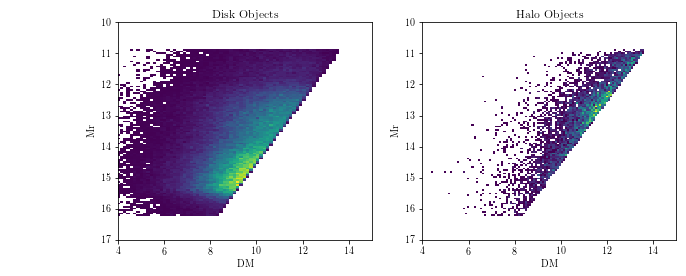

In [69]:
disk_objects['M_r'] = est_Mr(disk_objects['gObs']-disk_objects['rObs'])
disk_objects['DM'] = disk_objects['rObs'] - disk_objects['M_r']

halo_objects['M_r'] = est_Mr(halo_objects['gObs']-halo_objects['rObs'])
halo_objects['DM'] = halo_objects['rObs'] - halo_objects['M_r']

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10,4)

ax1.hist2d(disk_objects['DM'], disk_objects['M_r'], bins=100, cmin=1)
ax1.set_xlim([4, 15])
ax1.set_ylim([10, 17])
ax1.invert_yaxis()
ax1.set_xlabel('DM')
ax1.set_ylabel('Mr')
ax1.set_title('Disk Objects')

ax2.hist2d(halo_objects['DM'], halo_objects['M_r'], bins=100, cmin=1)
ax2.set_xlim([4, 15])
ax2.set_ylim([10, 17])
ax2.invert_yaxis()
ax2.set_xlabel('DM')
ax2.set_ylabel('Mr')
ax2.set_title('Halo Objects')
plt.show()


We define $x_\textrm{max}$ and $y_\textrm{max}$ values using $r^\textrm{faint}_\textrm{limit} = 24.5$ to give

$$ x_\textrm{max} = 24.5 - M_r $$
$$ y_\textrm{max} = 24.5 - DM $$

We plot the results from the Cminus bootstrap method as $\log(\rho)$ vs. $M_r$, where $\rho$ is a density given by dividing by a volume element $dV$ such that

$$dV = \tau \times \Omega \times d^2 $$

where $\tau$ is the thickness of the disk given by the range of distance modulus values, $\Omega$ is the solid angle given by integrating over the surface area of a sphere with $b < 60$, and $d$ is the distance given by the distance modulus values found above.

In [31]:
# Author: Jake VanderPlas
# License: BSD
# http://astroML.github.com
from astroML.lumfunc import bootstrap_Cminus

# Define the input distributions for x and y
# x = DM 
# y = M_r 
# x_max = 24.5 - M_r(gObs, rObs)
# y_max = 24.5 - rObs - M_r(gObs, rObs)

r_lim = 24.5

# -------Disk-------
# Calculate xmax, ymax
disk_objects['M_r'] = est_Mr(disk_objects['gObs']-disk_objects['rObs'])
disk_objects['DM'] = disk_objects['rObs'] - disk_objects['M_r']
disk_objects['max_DM'] = r_lim - disk_objects['M_r']
disk_objects['max_Mr'] = r_lim - disk_objects['DM']

# Set variables for Cminus implementation (disk)
xD = disk_objects['DM']
yD = disk_objects['M_r']
xmaxD = disk_objects['max_DM']
ymaxD = disk_objects['max_Mr']

# -------Halo-------
# Calculate xmax, ymax
#new_halo_objects = halo_objects[~halo_objects.index.isin([216660])]
halo_objects['M_r'] = est_Mr(halo_objects['gObs']-halo_objects['rObs'])
halo_objects['DM'] = halo_objects['rObs'] - halo_objects['M_r']
halo_objects['max_DM'] = r_lim - halo_objects['M_r']
halo_objects['max_Mr'] = r_lim - halo_objects['DM']

# Set variables for Cminus implementation (halo)
xH = halo_objects['DM']
yH = halo_objects['M_r']
xmaxH = halo_objects['max_DM']
ymaxH = halo_objects['max_Mr']

pd.DataFrame({'xH':xH,'yH':yH,'xmaxH':xmaxH, 'ymaxH': ymaxH}).to_csv('/Users/samanthagilbert/Desktop/debugging.csv', index=True, header=['xH', 'yH', 'xmaxH', 'ymaxH'], sep='\t') 

# aux arrays
x_fit = np.linspace(0, 15, 42)
y_fit = np.linspace(10, 17, 42)

xD, dxD, yD, dyD = bootstrap_Cminus(xD, yD, xmaxD, ymaxD, x_fit, y_fit, Nbootstraps = 5, normalize = True)
xH, dxH, yH, dyH = bootstrap_Cminus(xH, yH, xmaxH, ymaxH, x_fit, y_fit, Nbootstraps = 5, normalize = True)

In [116]:
#count_debug = disk_objects.loc[(disk_objects['DM'] < 9) & (7 < disk_objects['DM']) & (disk_objects['M_r'] < 15) & (14 < disk_objects['M_r'])]
#len(count_debug)

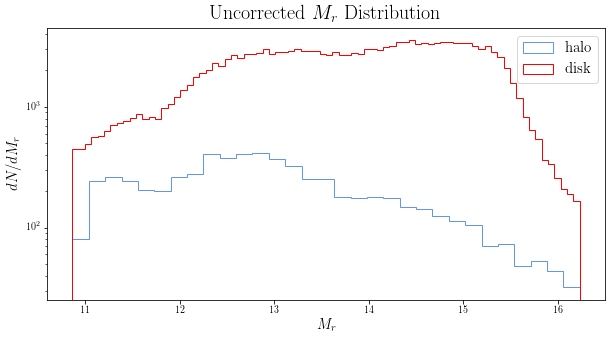

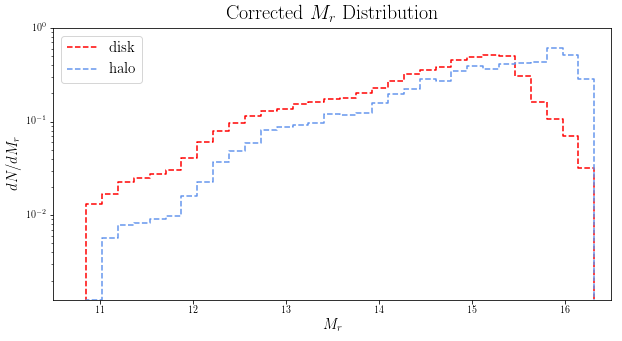

In [70]:
# Plot histograms of corrected/uncorrected M_r distributions
plt.figure(figsize=[10,5])
plt.hist(x=halo_objects['M_r'], bins='auto', color='cornflowerblue', label = 'halo', histtype='step')
plt.hist(x=disk_objects['M_r'], bins='auto', color='r', label = 'disk', histtype='step')
plt.yscale('log') 
plt.ylabel('$dN/dM_r$', fontsize=15)
plt.xlabel("$M_r$", fontsize=15)
plt.legend(fontsize=15)
plt.title('Uncorrected $M_r$ Distribution', fontsize=20)
plt.show()

plt.figure(figsize=[10,5])
plt.step(x=y_fit[1:], y=yD, color='r', linestyle='--', label = 'disk')
plt.step(x=y_fit[1:], y=yH, color='cornflowerblue', linestyle='--', label = 'halo')
plt.yscale('log') 
plt.ylim([-1e4,1])
plt.xlim([10.5,16.5])
plt.ylabel('$dN/dM_r$', fontsize=15)
plt.xlabel("$M_r$", fontsize=15)
plt.legend(fontsize=15)
plt.title('Corrected $M_r$ Distribution', fontsize=20)
plt.show()

In our uncorrected distribution, we see that the number of disk objects always exceeds that of halo objects, even at larger magnitudes. For a real sample, we expect halo objects to dominate disk objects at these larger absolute magnitudes, but our observations are biased towards collecting data on the nearer disk objects. Thus, our uncorrected distribution demonstrates this bias, while our corrected distribution removes it.

We now overplot the true luminosity function listed in files _WDlumfuncDisk.dat_ and _WDlumfuncHalo.dat_, to compare the (dis)agreement between our $\phi$ and the true $\phi$ for the disk and halo samples.

In [71]:
# Load in true halo and disk luminosity functions
halo_luminosity = pd.read_csv('./Desktop/galaxies_hw3/WDlumfuncHalo.dat', delim_whitespace=True)
halo_luminosity['LF_correct'] = halo_luminosity['LF']/200 # Fix a bug

disk_luminosity = pd.read_csv('./Desktop/galaxies_hw3/WDlumfuncDisk.dat', delim_whitespace=True)

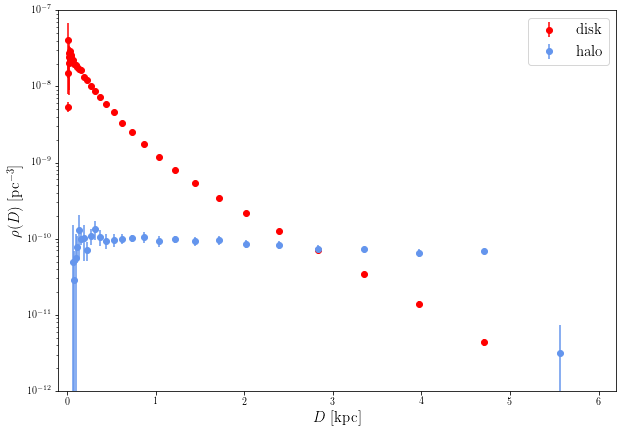

In [121]:
# Convert distances to parsecs
x_fit_pc = 10*10**(0.2 * x_fit) 

# Calculate solid angle and thickness of the disk
solid_angle = 2 * np.pi * quad(sinx, (5*np.pi)/6, np.pi)[0] # from our SA calculation in Problem A
thickness = (x_fit_pc[1:] - x_fit_pc[:-1]) 

# Reshape distances to match outputs from Cminus by calculating bin centers
centers = (x_fit_pc[1:] + x_fit_pc[:-1])/2

# Calculate a volume element using the formula dV = solid angle * thickness * distance^2
volume_element = solid_angle * centers**2 * thickness

plt.figure(figsize=[10,7])
plt.errorbar(centers*1e-3, (xD/(volume_element)), yerr=(dxD/(volume_element)), marker='o', ls='none', label='disk', color='r')
plt.errorbar(centers*1e-3, (xH/(volume_element)), yerr=(dxH/(volume_element)), marker='o', ls='none', label='halo', color='cornflowerblue')
plt.yscale('log') 
plt.ylim([1e-12,1e-7])
plt.xlim([-0.1,6.200])
plt.ylabel('$\\rho(D)$ [pc$^{-3}$]', fontsize=15)
plt.xlabel("$D$ [kpc]", fontsize=15)
plt.legend(fontsize=15)
plt.show()

### Normalization Procedure

We cannot stop here! We now need to **normalize** our densities according to the total star counts. We will carry this normalization procedure through to produce normalized luminosity functions, as well. Our normalization procedure is as follows:

1. Find the total star counts for disk and halo subsamples. 
2. Calculate normalized densities for disk and halo subsamples. 
3. Use re-scaled densities to find the density at $D = 0$ for disk and halo subsamples. 
4. Calculate normalized luminosity functions at $D = 0$ for disk and halo subsamples.

Steps 1-2 will normalize our $\rho(D)$ plot, while the final steps will normalize our $\Phi(M_r)$ plot. Note that we do not normalize by the fraction of sky coverage. This is because we have effectively already accounted for this effect when we divided our distributions by disk-shaped volume elements.

In [122]:
# Find total star counts for disk objects.
    
# Create a slice of DM and Mr space by defining DM_max and Mr_max
DM_max = 12
Mr_max = 12.5
    
# Count how many stars there are within this slice
new_disk_slice = np.logical_and(disk_objects['DM'] < DM_max, disk_objects['M_r'] < Mr_max)
n_disk = len(disk_objects[new_disk_slice])

new_halo_slice = np.logical_and(halo_objects['DM'] < DM_max, halo_objects['M_r'] < Mr_max)
n_halo = len(halo_objects[new_halo_slice])
    
# Slice xD and yD for x_fit < DM_max, y_fit < Mr_max respectively
mids_x = (x_fit[1:] + x_fit[:-1]) / 2
mids_y = (y_fit[1:] + y_fit[:-1]) / 2

xD_slice = xD[mids_x <= DM_max]
yD_slice = yD[mids_y <= Mr_max]

# Calculate the area of each bin in the disk distributions from Cminus
DMbin_width = x_fit[1] - x_fit[0] # All bins have equal width
Mrbin_width = y_fit[1] - y_fit[0]

DM_areas_disk = xD_slice * DMbin_width
Mr_areas_disk = yD_slice * Mrbin_width

# Calculate the area under the curve for this new disk subsample for DM and M_r each via Riemann sum
CDF_DM_disk = np.sum(DM_areas_disk)
CDF_Mr_disk = np.sum(Mr_areas_disk)

# Repeat for halo
xH_slice = xH[mids_x <= DM_max]
yH_slice = yH[mids_y <= Mr_max]

DM_areas_halo = xH_slice * DMbin_width
Mr_areas_halo = yH_slice * Mrbin_width
    
CDF_DM_halo = np.sum(DM_areas_halo)
CDF_Mr_halo = np.sum(Mr_areas_halo)

# Calculate constants C = flux-limited number of stars / (%DM * %Mr)
C_D = n_disk / (CDF_DM_disk * CDF_Mr_disk)
C_H = n_halo / (CDF_DM_halo * CDF_Mr_halo)

Now that we have calculated our correction to account for the fact that our samples are flux-limited, we now re-calculate and replot stellar densities as a function of distance for both disk and halo subsamples.

In [154]:
# Re-calculate densities = C * output from Cminus * DM/dV
    # Need to add a correction factor from converting from DM to distance: dDM/dV
    # dDM/dV = 5/(ln(10) * D^3 * solid angle)
disk_corrected = xD*C_D*(5 / (np.log(10)*x_fit_pc[:-1]**3*solid_angle))
disk_err_corrected = dxD*C_D*(5 / (np.log(10)*x_fit_pc[:-1]**3*solid_angle))

halo_corrected = xH*C_H*(5 / (np.log(10)*x_fit_pc[:-1]**3*solid_angle))
halo_err_corrected = dxH*C_H*(5 / (np.log(10)*x_fit_pc[:-1]**3*solid_angle))

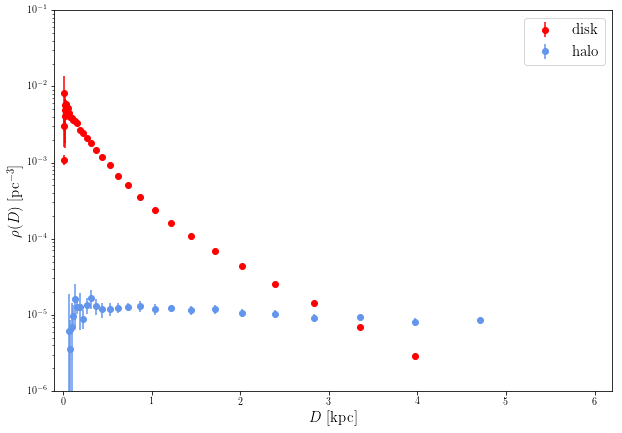

In [157]:
# Plot re-scaled densities
plt.figure(figsize=[10,7])
plt.errorbar(centers*1e-3, disk_corrected, yerr=disk_err_corrected, marker='o', ls='none', label='disk', color='r')
plt.errorbar(centers*1e-3, halo_corrected, yerr=halo_err_corrected, marker='o', ls='none', label='halo', color='cornflowerblue')
plt.yscale('log') 
plt.ylim([1e-6,0.1])
plt.xlim([-0.1,6.200])
plt.ylabel('$\\rho(D)$ [pc$^{-3}$]', fontsize=15)
plt.xlabel("$D$ [kpc]", fontsize=15)
plt.legend(fontsize=15)
plt.show()

Now that we have corrected density distributions, we will find the densities at $D = 0$. For the disk subsample, we will fit an exponential to the corrected densities, and extrapolate to zero to find $\rho_D(D=0)$. For the halo subsample, we will take the median from $D = 2$ kpc to $D = 5$ kpc to find $\rho_H(D=0)$.

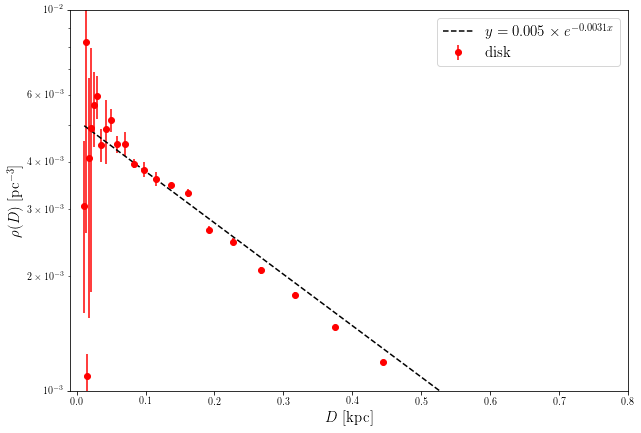

In [161]:
# Define an exponential to fit to the disk
def exp_fit(x, a, b):
    return a * np.exp(-b * x) 

# Fit the exponential to the data using curve_fit
popt, pcov = scipy.optimize.curve_fit(exp_fit, centers, disk_corrected) 

# Plot the points with fit for comparison     
plt.figure(figsize=[10,7])
plt.errorbar(centers*1e-3, disk_corrected, yerr=disk_err_corrected, marker='o', ls='none', label='disk', color='r')
plt.plot(centers*1e-3, exp_fit(centers, popt[0], popt[1]), 
         linestyle='--', 
         color='k', 
         label='$y = {:.3f}\\times e^{{-{:.4f}x}}$'.format(popt[0], popt[1]))
plt.xlabel('$D$ [kpc]', fontsize=15)
plt.ylabel("$\\rho(D)$ [pc$^{-3}$]", fontsize=15)
plt.legend(fontsize=15)
plt.yscale('log') 
plt.ylim([1e-3,1e-2])
plt.xlim([-0.01,0.8])
plt.show()

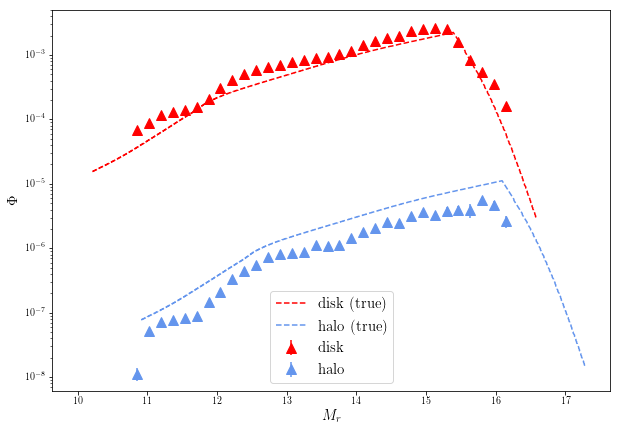

In [162]:
# Calculate rho(D = 0) for the disk subsample by taking the fit function at D=0
rhod0_disk = exp_fit(0, popt[0], popt[1]) 

# Calculate rho(D = 0) for the halo subsample by taking the median of the points between 2 and 5 kpc
rhod0_halo = np.median(halo_corrected[np.logical_and(centers > 2000, centers < 5000)])

# Plot density as a function of x_fit in pc
    # Multiply by RhoD0 for disk, halo
plt.figure(figsize=[10,7])
plt.errorbar(disk_luminosity['Mr'], disk_luminosity['LF'], ls='--', label='disk (true)', color='r')
plt.errorbar(halo_luminosity['Mr'], halo_luminosity['LF_correct'], ls='--', label='halo (true)', color='cornflowerblue')
plt.errorbar(y_fit[:-1], yD*rhod0_disk, yerr=dyD*rhod0_disk, marker='^', markersize=10, ls='none', label='disk', color='r')
plt.errorbar(y_fit[:-1], yH*rhod0_halo, yerr=dyH*rhod0_halo, marker='^', markersize=10, ls='none', label='halo', color='cornflowerblue')
plt.yscale('log') 
plt.ylabel('$\\Phi$', fontsize=15)
plt.xlabel("$M_r$", fontsize=15)
plt.legend(fontsize=15)
plt.show()

Our corrected disk luminosity functions correspond nicely to the true luminosity functions we were provided. However, the halo points appear to be off by a factor of 2 from the true luminosity functions. I am not sure why there is this discrepancy, and it seems odd that one subsample should have the bug and not the other. We can potentially attribute this discrepancy to the relative incompleteness of the halo subsample. We previously calculated the completeness of this subsample to be 64\%.

### Problem E 

In **Part D**, we plotted  $\ln{\rho}$ vs. $Z$, with error bars for disk and halo subsamples. Here, we will reproduce this plot and compare these profiles to the spatial profiles we determined in **Homework #1**. 

In **Homework #1**, we plotted the stellar density profile as a function of distance for stars with $0.2 < g - r < 0.4 $ between 9 and 10 kpc, and extrapolated this relationship out to 100 kpc in order to estimate the total number of stars between 90 and 100 kpc. 

We fit a power law to the spatial density profile to extrapolate to these farther distances, finding

$$ \rho = 2.4 \times 10^5 D^{-3} $$

We anticipate that this power law will be a better match to the disk profile as compared to the halo profile, given the disk profile we produced follows the shape of a power law while the halo profile looks more like a flat line.

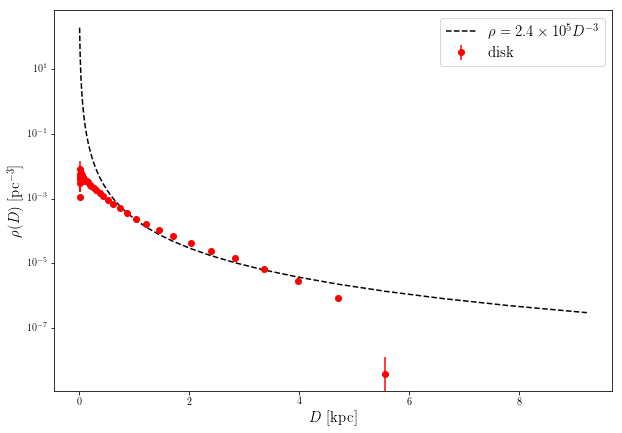

In [163]:
x = centers*1e-3
x_pc = centers

plt.figure(figsize=[10,7])
plt.errorbar(x, disk_corrected, yerr=disk_err_corrected, marker='o', ls='none', label='disk', color='r')
plt.plot(x, 2.4e5*x_pc**-3, color='k', linestyle='--', label='$\\rho = 2.4\\times10^5D^{-3}$')
plt.yscale('log') 
plt.ylabel('$\\rho(D)$ [pc$^{-3}$]', fontsize=15)
plt.xlabel("$D$ [kpc]", fontsize=15)
plt.legend(fontsize=15)
plt.show()

Overall, the spatial profile from Homework 1 does a really shoddy job of matching the observed spatial profiles! It looks like a decent fit at smaller distances, e.g., 1-1.5 kpc, but it readily diverges from our data at larger distances. This makes sense, as we split our halo and disk samples in Homework 1 based on metallicity. We knew this was a problematic sorting scheme because we had systematic photometric errors that caused us to misclassify low metallicity stars as high metallicity stars. In this homework, we've used a more sophisticated method for sorting halo and disk stars, so it makes sense that our crude profile does not match our disk data points here.